<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/auduvignac/challengedata_ens_AssurPrime/blob/main/notebooks/exploration/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

##Installation de category-encoder

In [1]:
#pip install category-encoders

In [2]:
#pip install -U scikit-learn


##Importation des bibliothèques

In [3]:
#pip install -U xgboost

In [4]:
#pip install -U imblearn

In [5]:
# Importer les bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
from category_encoders import CountEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, fbeta_score, mean_squared_error, make_scorer
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from imblearn.ensemble import EasyEnsembleClassifier

##Chargement des données

In [6]:
# Charger les données
try:
  print("Chargement des données...")
  X_train_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/x_train.csv"
  X_train = pd.read_csv(X_train_url)
  y_train_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/y_train.csv"
  y_train = pd.read_csv(y_train_url)
  #X_test_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/x_test.csv"
  #X_test = pd.read_csv(X_test_url)
  print("Données chargées avec succès.")
except:
  print("Erreur lors du chargement des données. Vérifiez que les URLs sont correctes.")

Chargement des données...


/var/folders/cz/_qd42vtn1nbbcf9dwk6sg5tw0000gn/T/ipykernel_956/3323000319.py:5: DtypeWarning: Columns (16,17,29,30,31,126,128,129,132,133,135,138,371) have mixed types. Specify dtype option on import or set low_memory=False.
  X_train = pd.read_csv(X_train_url)


Données chargées avec succès.


##Analyse des données

In [7]:
# Afficher un aperçu des données pour vérifier leur chargement
print("Aperçu de X_train :")
display(X_train.head())
print("Aperçu de y_train :")
display(y_train.head())
#print("Aperçu de X_test :")
#display(X_test.head())

Aperçu de X_train :


,ID,ACTIVIT2,VOCATION,TYPERS,ANCIENNETE,ADOSS,CARACT1,CARACT2,CARACT3,INDEM1,...,NBJRR100_MMAX_A,NBJRR100_MSOM_A,RR_VOR_MM_A,RR_VOR_MMAX_A,RRAB_VOR_MM_A,RRAB_VOR_MMAX_A,ANNEE_ASSURANCE,ESPINSEE,AN_EXERC,ZONE
0,1,ACT1,VOC6,1,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,ANNEE5,3
1,2,ACT1,VOC6,1,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,ANNEE5,3
2,3,ACT1,VOC6,1,2,N,R,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,0.402740,NaN,ANNEE5,3
3,4,ACT1,VOC6,2,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,0.246575,NaN,ANNEE5,3
4,5,ACT1,VOC6,2,1,N,N,NaN,NaN,N,...,01. <= 0,01. <= 0,03. <= 102,03. <= 232,04. >= 25,02. <= 57,0.838356,NaN,ANNEE5,3


Aperçu de y_train :


,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE
0,1,0.0,0.0,1.000000,0.0
1,2,0.0,0.0,1.000000,0.0
2,3,0.0,0.0,0.402740,0.0
3,4,0.0,0.0,0.246575,0.0
4,5,0.0,0.0,0.838356,0.0


###Aperçu général des données

In [8]:
# 0. Afficher le type des données de X_train
pd.set_option('display.max_rows', None)

print("Types des données de X_train :")
print(X_train.dtypes)


Types des données de X_train :
ID                              int64
ACTIVIT2                       object
VOCATION                       object
TYPERS                          int64
ANCIENNETE                      int64
ADOSS                          object
CARACT1                        object
CARACT2                       float64
CARACT3                        object
INDEM1                         object
DUREE_REQANEUF                float64
CARACT4                        object
CARACT5                         int64
TYPBAT1                        object
INDEM2                         object
TYPBAT2                         int64
FRCH1                          object
FRCH2                          object
DEROG1                         object
DEROG2                         object
DEROG3                         object
DEROG4                         object
DEROG5                         object
DEROG6                         object
DEROG7                         object
DEROG8             

###Analyse
Des colonnes qui semblent être de même nature, ne sont pas de même type. Par exemple : Kapitalnn (int64, float64 et object)

Il y a beaucoup de caractéristiques (374) et la plupart sont de type 'object'.

In [9]:
# 2. Calcul des valeurs manquantes
nb_missing = X_train.isnull().sum()
taux_missing = X_train.isnull().mean() * 100

# Création d'un DataFrame combiné
missing_info = pd.DataFrame({
    'Valeurs manquantes': nb_missing,
    'Taux (%)': taux_missing.round(2)
})

# Filtrage pour ne garder que les colonnes avec au moins une valeur manquante
missing_info = missing_info[missing_info['Valeurs manquantes'] > 0]

print(missing_info)

                            Valeurs manquantes  Taux (%)
CARACT1                                   4633      1.21
CARACT2                                 368284     96.00
CARACT3                                 368284     96.00
DUREE_REQANEUF                           26573      6.93
TYPBAT1                                 353336     92.11
INDEM2                                   27372      7.14
FRCH2                                    26573      6.93
DEROG12                                 349078     91.00
DEROG13                                 382317     99.66
DEROG14                                 383602    100.00
DEROG16                                 380358     99.15
KAPITAL11                               119005     31.02
KAPITAL15                                  624      0.16
KAPITAL16                                 1582      0.41
KAPITAL17                                  889      0.23
KAPITAL18                                   48      0.01
KAPITAL19                      

###Analyse

***Beaucoup de valeurs manquantes** pour bon nombre de caratéristiques. L'enjeu est d'identifier les caractéristiques qui de ce fait n'apprendront rien au modèle pour les écarter et ainsi commencer à réduire le nombre de caractéristiques à prendre en compte.*

***Par exemple :** DEROGnn a plus de 380000 valeurs manquantes sur 383610 lignes, soit 99% de valeurs manquantes. A minima pour prédire la frequence du risque incendie on peut considérer les caractérisques DEROGnn comme inutiles.*

Il convient d'arbitrer pour chaque caractéristique, fonction de la cible à prédire (Freq ou CN). Pour cela nous allons dans un premier temps calculer le taux de valeurs manquantes.

In [10]:
# 3. Analyse des valeurs uniques
unique_values = X_train.nunique()
print("\nNombre de valeurs uniques par colonne :")
print(unique_values)


Nombre de valeurs uniques par colonne :
ID                            383610
ACTIVIT2                           9
VOCATION                           8
TYPERS                             2
ANCIENNETE                        12
ADOSS                              2
CARACT1                            3
CARACT2                            2
CARACT3                            3
INDEM1                             2
DUREE_REQANEUF                     4
CARACT4                            6
CARACT5                           16
TYPBAT1                            5
INDEM2                            12
TYPBAT2                            3
FRCH1                              9
FRCH2                              6
DEROG1                             2
DEROG2                             2
DEROG3                             2
DEROG4                             2
DEROG5                             2
DEROG6                             2
DEROG7                             2
DEROG8                            

###Analyse

On constate que beaucoup de caractéristiques ont un nombre de valeurs uniques limité (par exemple 4) et sont de type object. La table de contingence ci-dessous permet de constater que ces caractéristiques prennent pour valeur des plages de valeurs ("<= nn" ou ">= nn").

Pour les caclculs des modèles, il nous faut convertir ces objects en catégories numériques.

In [11]:
# 4. Table de contingence pour les variables catégorielles
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    print(f"\nTable de contingence pour {col} :")
    print(X_train[col].value_counts())


Table de contingence pour ACTIVIT2 :
ACTIVIT2
ACT1    296563
ACT5     53709
ACT2     14359
ACT8      5650
ACT3      5335
ACT9      4459
ACT7      2201
ACT6      1007
ACT4       327
Name: count, dtype: int64

Table de contingence pour VOCATION :
VOCATION
VOC6    244441
VOC8     67446
VOC7     38967
VOC4     15289
VOC1     14359
VOC2      1952
VOC3      1081
VOC5        75
Name: count, dtype: int64

Table de contingence pour ADOSS :
ADOSS
N    375557
O      8053
Name: count, dtype: int64

Table de contingence pour CARACT1 :
CARACT1
N    274335
R     93158
O     11484
Name: count, dtype: int64

Table de contingence pour CARACT3 :
CARACT3
N    7433
O    6795
R    1098
Name: count, dtype: int64

Table de contingence pour INDEM1 :
INDEM1
N    365728
O     17882
Name: count, dtype: int64

Table de contingence pour CARACT4 :
CARACT4
absence de surface    365009
Surface de moins d     10343
Surface entre 501       5205
Surface entre 1001      1600
Surface entre 1501       933
Surface de plus d

In [12]:
# 1. Aperçu des données - informations statistiques
print("\nAperçu des données :")
print(X_train.info())
#print("\nRésumé statistique :")
#print(X_train.describe(include='all'))



Aperçu des données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Columns: 374 entries, ID to ZONE
dtypes: float64(36), int64(58), object(280)
memory usage: 1.1+ GB
None


In [13]:
# Traitement des valeurs manquantes dans les colonnes numériques
print("Traitement des valeurs manquantes dans les colonnes numériques...")
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Remplir les NaN avec 0 pour les colonnes numériques
X_train[numeric_columns] = X_train[numeric_columns].fillna(0)

# Identifier les colonnes non numériques
fill_cols = [item for item in X_train.columns if item not in numeric_columns]

# Remplir les NaN des colonnes non numériques avec une valeur par défaut (-999)
X_train[fill_cols] = X_train[fill_cols].fillna(-999)

print("Traitement des valeurs manquantes terminé.")

Traitement des valeurs manquantes dans les colonnes numériques...
Traitement des valeurs manquantes terminé.


In [14]:
# Préparation des données pour l'entraînement
print("Préparation des données pour l'entraînement...")

# Suppression des colonnes inutiles
X_train = X_train.drop(['ID', 'ANNEE_ASSURANCE'], axis=1)

# Encodage des variables catégoriques avec CountEncoder
encoder = CountEncoder(cols=fill_cols)
encoder.fit(X_train)
X_train_enc = encoder.transform(X_train)

print("Préparation terminée.")

Préparation des données pour l'entraînement...
Préparation terminée.


###Sélection des features significatives

Essayons de ne conserver que la somme de certaines features : Kapital, Surface, NBBat

In [15]:
# Remplacement des groupes de variables par leur somme

# Somme des colonnes KAPITAL1 à KAPITAL43
kapital_cols = [f'KAPITAL{i}' for i in range(1, 44)]
X_train_enc['KAPITAL'] = X_train_enc[kapital_cols].sum(axis=1)
X_train_enc = X_train_enc.drop(columns=kapital_cols)

# Somme des colonnes SURFACE1 à SURFACE21
surface_cols = [f'SURFACE{i}' for i in range(1, 22)]
X_train_enc['SURFACE'] = X_train_enc[surface_cols].sum(axis=1)
X_train_enc = X_train_enc.drop(columns=surface_cols)

# Somme des colonnes NBAT1 à NBAT14
nbat_cols = [f'NBBAT{i}' for i in range(1, 12)]
X_train_enc['NBBAT'] = X_train_enc[nbat_cols].sum(axis=1)
X_train_enc = X_train_enc.drop(columns=nbat_cols)

print("Remplacement des groupes de variables par leur somme terminé.")

/var/folders/cz/_qd42vtn1nbbcf9dwk6sg5tw0000gn/T/ipykernel_956/2870516456.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_enc['KAPITAL'] = X_train_enc[kapital_cols].sum(axis=1)
/var/folders/cz/_qd42vtn1nbbcf9dwk6sg5tw0000gn/T/ipykernel_956/2870516456.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_enc['SURFACE'] = X_train_enc[surface_cols].sum(axis=1)


Remplacement des groupes de variables par leur somme terminé.


/var/folders/cz/_qd42vtn1nbbcf9dwk6sg5tw0000gn/T/ipykernel_956/2870516456.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_enc['NBBAT'] = X_train_enc[nbat_cols].sum(axis=1)


In [16]:
print(X_train_enc.head())

   ACTIVIT2  VOCATION  TYPERS  ANCIENNETE   ADOSS  CARACT1  CARACT2  CARACT3  \
0    296563    244441       1           0  375557   274335      0.0   368284   
1    296563    244441       1           0  375557   274335      0.0   368284   
2    296563    244441       1           2  375557    93158      0.0   368284   
3    296563    244441       2           0  375557   274335      0.0   368284   
4    296563    244441       2           1  375557   274335      0.0   368284   

   INDEM1  DUREE_REQANEUF  ...  RR_VOR_MM_A  RR_VOR_MMAX_A  RRAB_VOR_MM_A  \
0  365728             0.0  ...       217712         217712         217712   
1  365728             0.0  ...       217712         217712         217712   
2  365728             0.0  ...       217712         217712         217712   
3  365728             0.0  ...       217712         217712         217712   
4  365728             0.0  ...        29090          28446          18988   

   RRAB_VOR_MMAX_A  ESPINSEE  AN_EXERC  ZONE    KAPITAL 

Sélection des lignes. Filtre de ce qui semble être des outliers

On filtre les lignes pour lesquelles CN est négatif ou FREQ est >100

In [17]:
# Filtrer les lignes où y_train['CM'] < 0 ou y_train['FREQ'] > 100
mask = (y_train['CM'] >= 0) & (y_train['FREQ'] <= 100)

# Appliquer le masque pour filtrer les données
X_train_enc_filtered = X_train_enc[mask]
y_train_filtered = y_train[mask]

print(f"Nombre de lignes après filtrage : {len(X_train_enc_filtered)}")

Nombre de lignes après filtrage : 383603


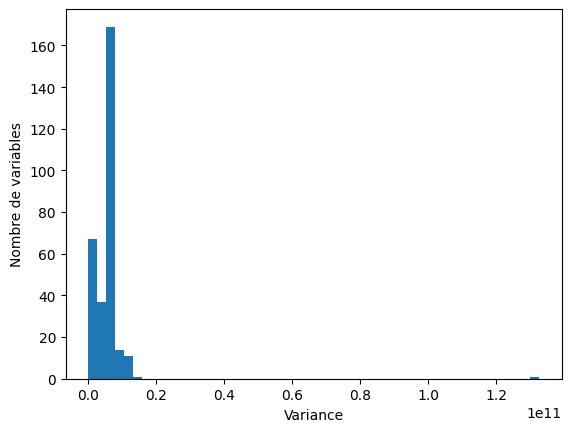

In [18]:
import matplotlib.pyplot as plt
variances = X_train_enc_filtered.var()
plt.hist(variances, bins=50)
plt.xlabel("Variance")
plt.ylabel("Nombre de variables")
plt.show()


In [19]:
print(variances[variances < 5e8].index)

Index(['TYPERS', 'ANCIENNETE', 'CARACT2', 'DUREE_REQANEUF', 'CARACT5',
       'TYPBAT2', 'DEROG1', 'DEROG7', 'DEROG13', 'DEROG14', 'DEROG15', 'CA1',
       'CA2', 'CA3', 'NBBAT13', 'NBBAT14', 'TAILLE3', 'TAILLE4', 'NBSINCONJ',
       'NBSINSTRT', 'RISK1', 'RISK2', 'RISK3', 'RISK4', 'RISK5', 'RISK7',
       'EQUIPEMENT1', 'EQUIPEMENT3', 'EQUIPEMENT4', 'EQUIPEMENT6',
       'EQUIPEMENT7', 'LOG_AVA1', 'ZONE_VENT', 'AN_EXERC', 'ZONE', 'NBBAT'],
      dtype='object')


Filtrage des features qui ont une faible variance

In [22]:
from sklearn.feature_selection import VarianceThreshold

# Suppression des colonnes avec une faible variance
print("Suppression des colonnes avec une faible variance...")
selector = VarianceThreshold(threshold=0.05)  # Seuil de variance, ajustez si nécessaire
X_train_reduced = selector.fit_transform(X_train_enc_filtered)

# Mise à jour des colonnes restantes
columns_retained = X_train_enc_filtered.columns[selector.get_support()]
X_train_enc_filtered_all = pd.DataFrame(X_train_reduced, columns=columns_retained)

print(f"Colonnes restantes après filtrage : {len(columns_retained)}")

Suppression des colonnes avec une faible variance...
Colonnes restantes après filtrage : 299


##Analyse de la distribution des cibles CM et FREQ

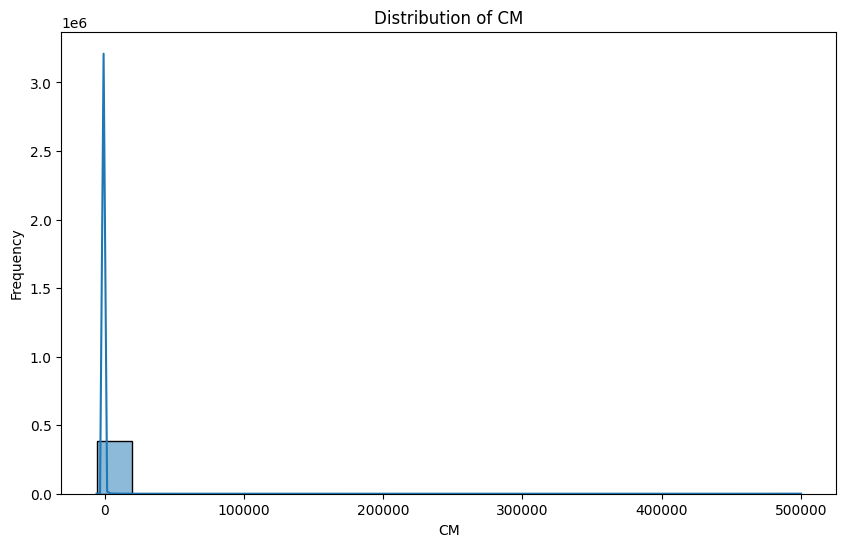

In [23]:
# Graphe de distribution de y_train['CM']

plt.figure(figsize=(10, 6))
sns.histplot(y_train['CM'], kde=True)  # Use histplot for distribution
plt.title('Distribution of CM')
plt.xlabel('CM')
plt.ylabel('Frequency')
plt.show()

###Commentaires :
la distribution est très déséquilibrée et mérite une analyse plus précise en listant les valeurs de CM

In [24]:
# Frequence (nombre d'occurrence) de chaque valeur de y_train['CM'] par ordre croissant de CM
pd.set_option('display.max_rows', None)

cm_frequencies = y_train_filtered['CM'].value_counts().sort_index()

# Print des fréquences
cm_frequencies

CM
0.000000         381252
1.000000              1
17.500000             1
19.400000             1
20.000000             1
23.320000             1
25.000000             1
30.000000             1
32.550000             1
38.500000             1
40.000000             1
41.100000             1
45.000000             1
46.030000             1
47.500000             1
48.000000             1
49.000000             1
49.360000             1
49.820000             1
50.000000             2
51.500000             1
53.090000             1
54.910000             1
55.000000             1
57.190000             1
58.000000             1
59.200000             1
60.000000             2
60.400000             1
60.410000             1
62.500000             2
62.800000             1
63.800000             1
65.000000             2
65.910000             1
66.940000             1
67.130000             1
70.000000             1
73.000000             1
75.000000             3
75.700000             1
76.800000    

###Commentaires :
Nous constatons que **381252 lignes ont une valeur CM = 0**.

Par ailleurs, nous observons 6 valeurs négatives étranges pour un coût moyen (il peut s'agir de régularisation de comptes suite à des trop versés, ...). A voir si on conservera ces quelques observations pour l'entrainement de CM.

Il convient à présent d'analyser ce qu'il en est de FREQ.

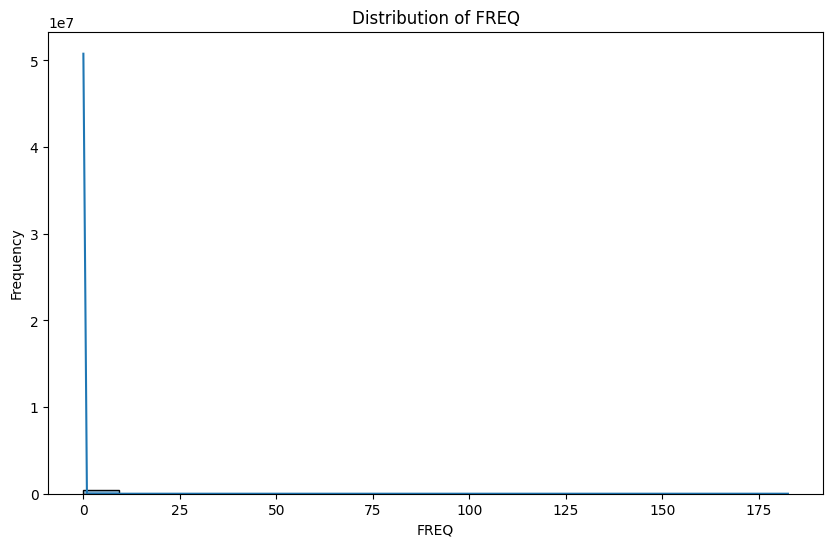

In [25]:
# Graphe de distribution de y_train['FREQ']

plt.figure(figsize=(10, 6))
sns.histplot(y_train['FREQ'], kde=True)  # Use histplot for distribution
plt.title('Distribution of FREQ')
plt.xlabel('FREQ')
plt.ylabel('Frequency')
plt.show()

###Commentaires :
On observe une distribution semblable à CM. Vérifions avec les valeurs.

In [26]:
# Frequence (nombre d'occurrence) de chaque valeur de y_train['FREQ'] par ordre croissant de FREQ

freq_frequencies = y_train_filtered['FREQ'].value_counts().sort_index()

# Print des frequence de chaque FREQ par ordre croissant
freq_frequencies

FREQ
0.000000     380716
0.968170          1
1.000000       1446
1.002747          3
1.005510          1
1.008287          2
1.011080          3
1.013889          3
1.016667          1
1.016713          2
1.022409          3
1.025210          1
1.025281          8
1.028090          1
1.028169          1
1.031073          1
1.033898          1
1.033994          3
1.036827          1
1.036932          1
1.039773          2
1.039886          7
1.042857          3
1.045714          1
1.045845          4
1.045845          2
1.048851          3
1.054913          4
1.057803          1
1.057971          4
1.061047          2
1.064140          1
1.067055          2
1.067251          2
1.070381          1
1.070381          2
1.073314          1
1.073529          3
1.076696          5
1.079646          1
1.079882          3
1.082840          1
1.083086          4
1.086310          2
1.089552          6
1.092537         10
1.092814         46
1.095808          1
1.096096          5
1.099398       

###Commentaires :
Nous observons que 380716 lignes ont une valeur FREQ = 0.

Nous sommes donc dans le cas d'une base de données des contrats d'assurance qui ne recense que les sinsitres incendies, pour laquelle sur 383610 contrats, 380716 n'ont eu aucun sinistres et donc aucun coût de sinistre.

Heureusement, s'agissant d'une assurance, moins de 1% des contrats ont connu un sinistre incendie.

A noter que 536 contrats (381252 - 380716) ont eu un sinistre dont le coût moyen CM est égal à zéro. Il peut s'agir de sinistres dont le coût est inférieur à des franchises. Il nous semble intéressant de préserver ces cas dans l'apprentissage des CM.

A noter également que sur les 2894 contrats qui ont eu FREQ > 0 il y en a 1446 dont la FREQ = 1.

##Structuration de modèles

Compte tenu des constats sur les cibles, il apparaît judicieux de bâtir un modèle à deux étages.

Un premier étage constitué par une classification binaire sur la base de FREQ = 0 ou FREQ > 0

Un second étage de regression linéaire pour prédire FREQ et CM sachant que FREQ > 0.

Nota Bene : nous nous contenterons de la classification binaire sur FREQ afin de préserver pour la régression linéaire de CM les cas de FREQ > 0 ET CM = 0 qui peuvent s'expliquer par des effets de franchises et qui sont utiles à l'apprentissage de CM.

###Chargement complémentaire de bibliothèques

###Fonction de classification et fonction de calcul du seuil optimal pour la classification binaire
L'imbalance est très important dans cette classification puisque 99% des observation appartiennent à une classe et 1% à l'autre classe. Le seuil de 0,5 pris par défaut n'est pas nécessairement le meilleur dans ce cas pour avoir un bon recall des FREQ > 0 en préservant une précision acceptable.

Cette fonction cherche le meilleur compromis.

In [27]:
def train_classifier(X, y_binary, param_grid, gridsearch=False, scale_pos_weight=99):
    
    if gridsearch:
      clf = XGBClassifier(eval_metric='aucpr', random_state=42)
      search_clf = GridSearchCV(clf, param_grid, scoring='neg_log_loss', cv=3, verbose=1)
      search_clf.fit(X, y_binary)
      clf = search_clf.best_estimator_
      print("Meilleurs paramètres Classifieur:", search_clf.best_params_)

    else:   
        clf = XGBClassifier(
                use_label_encoder=False,
                objective='binary:logistic',
                eval_metric='aucpr',
                scale_pos_weight=scale_pos_weight,
                n_estimators=200,
                max_depth=4,
                learning_rate=0.05,
                subsample=0.72,
                colsample_bytree=0.7,
                n_jobs=-1,
                verbosity=0,
                random_state=42
            )

        clf.fit(X, y_binary)
        print("Meilleurs paramètres Classifieur:", clf.get_params())
    return clf

def find_best_threshold(y_true, y_proba, beta=2, thresholds=np.linspace(0.01, 0.99, 200)): # un pas de 1/200 iso 1/100 permet de gagner 20 points sur le rmse avec beta = 2
    best_thresh, best_score = 0, 0
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        score = fbeta_score(y_true, y_pred, beta=beta)
        if score > best_score:
            best_thresh, best_score = t, score
    return best_thresh, best_score

###Fonction de régression linéaire pour FREQ et CM

In [30]:
def train_regressors_freq(X, y_freq, mask, param_grid, gridsearch=False):
    X_sub = X[mask]
    print(f"Forme de X_sub : {X_sub.shape}")
    y_freq_sub = y_freq[mask]

    if gridsearch:
      reg_freq = XGBRegressor(n_jobs=-1, verbosity=0, random_state=42)
      search_reg_freq = GridSearchCV(reg_freq, param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=1)
      search_reg_freq.fit(X_sub, y_freq_sub)
      reg_freq = search_reg_freq.best_estimator_
      print("Meilleurs paramètres Régresseur FREQ:", search_reg_freq.best_params_)

    else :
      reg_freq = XGBRegressor(n_jobs=-1, verbosity=0,random_state=42,
      scale_pos_weight=50,
      max_depth = 3,
      learning_rate = 0.01,
      n_estimators = 200,
      subsample = 0.75)
      
      reg_freq.fit(X_sub, y_freq_sub)

    return reg_freq, X_sub, y_freq_sub


In [33]:
def train_regressors_cm(X, y_cm, mask, param_grid, gridsearch = False):
    X_sub = X[mask]
    print(f"Forme de X_sub : {X_sub.shape}")
    y_cm_sub = y_cm[mask]

    if gridsearch:
      reg_cm = XGBRegressor(n_jobs=-1, verbosity=0, random_state=42)
      search_reg_cm = GridSearchCV(reg_cm, param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=1)
      search_reg_cm.fit(X_sub, y_cm_sub)
      reg_cm = search_reg_cm.best_estimator_
      print("Meilleurs paramètres Régresseur CM:", search_reg_cm.best_params_)

    else :
      reg_cm = XGBRegressor(n_jobs=-1, verbosity=0, random_state=42,
      max_depth = 3,
      learning_rate = 0.01,
      n_estimators = 200,
      subsample = 0.8)
      
      reg_cm.fit(X_sub, y_cm_sub)

    return reg_cm, X_sub, y_cm_sub

###Pipeline enchaînant les étages
Il restitue les modèles entraînés.

**Nota Bene :** dans l'enchaînement des étages run_pipeline() entraîne CM et FREQ sur une extraction de la base qui répond au critère "mask_classified_pos = y_pred_class == 1". Donc sur la base des FREQ > 0 estimé par le classifieur, y compris des faux positifs, et non pas sur la base réel de y_binary. **A voir si c'est la meilleure stratégie.**

In [39]:
def run_pipeline(X, y, beta=2):
    # Etape 0 préparation des gridsearch
    gridsearch_clf = False
    gridsearch_freq = False
    gridsearch_cm = False

    param_grid_clf = {
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.02],
    'n_estimators': [240, 250, 260],
    'subsample': [0.71, 0.72, 0.73]
}

    param_grid_freq = {
    'max_depth': [3, 4, 5],    
    'learning_rate': [0.01],
    'n_estimators': [100, 120],
    'subsample': [0.71, 0.72, 0.73]
}

    param_grid_cm = {
    'max_depth': [2, 3],    
    'learning_rate': [0.01],
    'n_estimators': [100, 120],
    'subsample': [0.72, 0.75, 0.8]
}

    # Étape 1 : classification
    y_binary = (y['FREQ'] > 0).astype(int)
    clf = train_classifier(X, y_binary, param_grid_clf, gridsearch=gridsearch_clf)

    #
    y_proba = clf.predict_proba(X)[:, 1]

    threshold, fbeta = find_best_threshold(y_binary, y_proba, beta=beta)
    print(f"Meilleur seuil (F{beta}): {threshold:.2f} - Score: {fbeta:.3f}")

    y_pred_class = (y_proba >= threshold).astype(int)
    print(classification_report(y_binary, y_pred_class, digits=3))

    # Étape 2 : entraînement des régressions sur les cas classés 1
    mask_classified_pos = y_pred_class == 1


    reg_freq, X_sub, y_freq_sub = train_regressors_freq(X, y['FREQ'], mask_classified_pos, param_grid_freq, gridsearch = gridsearch_freq)
    reg_cm, X_sub, y_cm_sub = train_regressors_cm(X, y['CM'], mask_classified_pos, param_grid_cm, gridsearch = gridsearch_cm)


    return clf, threshold, reg_freq, reg_cm, X_sub, y_freq_sub, y_cm_sub


###Fonction de génération de graphique des features ayant le plus d'importance pour un modèle

In [40]:
# Affichage des features par importance pour le modèle
def plot_feature_importance(model, X, top_n=30):
    importance = model.feature_importances_
    features = X.columns
    df = pd.DataFrame({'Feature': features, 'Importance': importance})
    df = df.sort_values('Importance', ascending=False).head(top_n)

    df.plot(kind='barh', x='Feature', y='Importance', figsize=(10, 8))
    plt.gca().invert_yaxis()
    plt.title('Top Features')
    plt.show()


###Commentaire :
Il est à noter que l'importance des features dépend des paramètres des modèles. Il y a notamment de fortes variations lorsque l'on fait varier les paramètres de l'étape de classification.

###Fonction pipeline de prédiction

In [41]:
def predict_pipeline(X, clf, threshold, reg_freq, reg_cm):
    
    y_proba = clf.predict_proba(X)[:, 1]
    mask = y_proba >= threshold

    freq_pred = np.zeros(X.shape[0])
    cm_pred = np.zeros(X.shape[0])

    if mask.sum() > 0:
        freq_pred[mask] = reg_freq.predict(X[mask])
        cm_pred[mask] = reg_cm.predict(X[mask])

    return freq_pred, cm_pred, y_proba


##Split de X et y pour avoir une base de test à évaluer

In [42]:
y_freq_binary = (y_train_filtered["FREQ"] > 0).astype(int)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_enc_filtered_all,
    y_train_filtered,                     # <--- garde toutes les colonnes de y_train
    test_size=0.2,
    stratify=y_freq_binary,     # <--- la stratification se fait uniquement sur FREQ
    random_state=42
)


###Génération des modèles

In [43]:
clf, threshold, reg_freq, reg_cm, X_sub, y_freq_sub, y_cm_sub = run_pipeline(X_train_split, y_train_split)

Meilleurs paramètres Classifieur: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'aucpr', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 99, 'subsample': 0.72, 'tree_method': None, 'validate_parameters': None, 'verbosity': 0, 'use_label_encoder': False}
Meilleur seuil (F2): 0.6

###Importance pour le modèle de FREQ

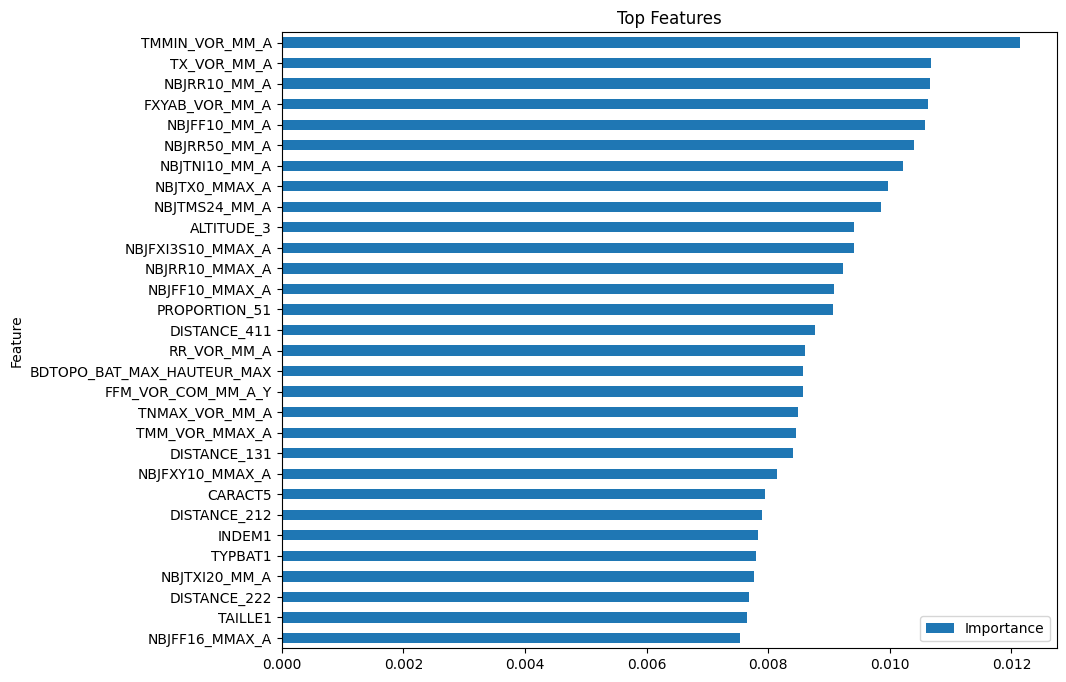

In [44]:
plot_feature_importance(reg_freq, X_sub)

###Importance pour le modèle de CM

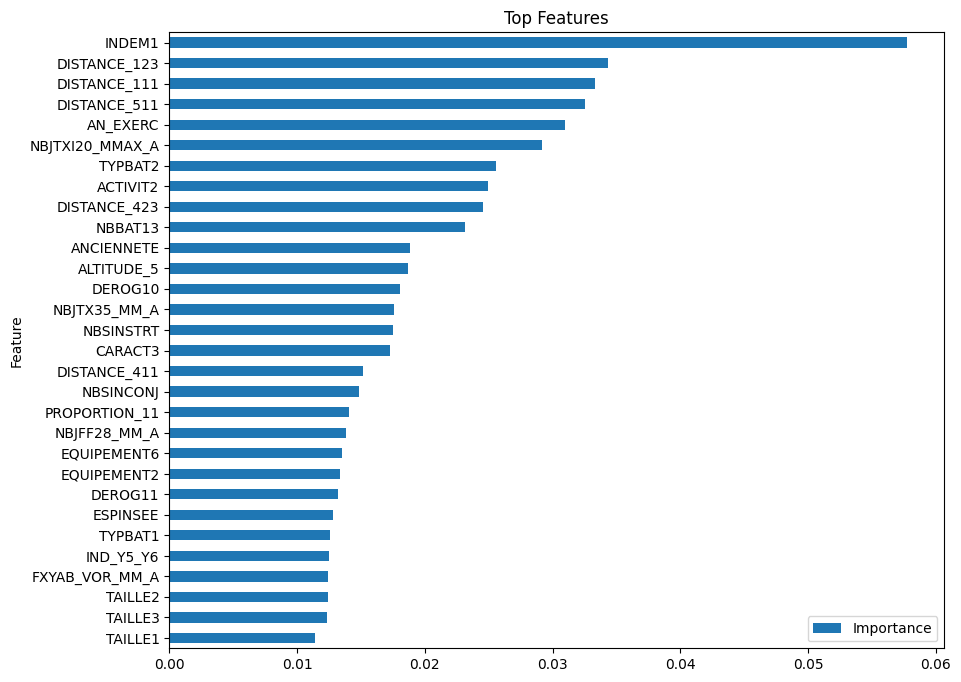

In [45]:
plot_feature_importance(reg_cm, X_sub, top_n=30)

###Génération des prédictions

In [46]:
freq_pred, cm_pred, infl_proba = predict_pipeline(X_train_split, clf, threshold, reg_freq, reg_cm)


###Evaluation

In [47]:
from sklearn.metrics import mean_squared_error

# Masque pour FREQ > 0
mask_true = (y_train_split['FREQ'] > 0)

# Extraction des valeurs réelles et prédictions alignées
y_freq_true = y_train_split.loc[mask_true, 'FREQ'].values
y_cm_true   = y_train_split.loc[mask_true, 'CM'].values

freq_pred_true = freq_pred[mask_true]
cm_pred_true   = cm_pred[mask_true]

# Calcul du RMSE (manuellement)
rmse_freq = np.sqrt(mean_squared_error(y_freq_true, freq_pred_true))
rmse_cm   = np.sqrt(mean_squared_error(y_cm_true, cm_pred_true))

# Affichage
print(f"FREQ - RMSE : {rmse_freq:.3f}")
print(f"CM   - RMSE : {rmse_cm:.3f}")


FREQ - RMSE : 2.238
CM   - RMSE : 72798.745


###Calcul de la prédiction combinée

In [48]:
# Calculer la prédiction combinée pour 'CHARGE'
y_train_pred = freq_pred * cm_pred * y_train_split['ANNEE_ASSURANCE']

In [49]:
# Calculer le RMSE sur l'ensemble d'entraînement
rmse = np.sqrt(mean_squared_error(y_train_split['CHARGE'], y_train_pred))
print(f"RMSE sur l'ensemble d'entraînement : {rmse:.2f}")

RMSE sur l'ensemble d'entraînement : 6535.76


###Prédiction sur le split test

In [50]:
freq_pred, cm_pred, infl_proba = predict_pipeline(X_val_split, clf, threshold, reg_freq, reg_cm)


In [51]:
from sklearn.metrics import mean_squared_error

# Masque pour FREQ > 0
mask_true = (y_val_split['FREQ'] > 0)

# Extraction des valeurs réelles et prédictions alignées
y_freq_true = y_val_split.loc[mask_true, 'FREQ'].values
y_cm_true   = y_val_split.loc[mask_true, 'CM'].values

freq_pred_true = freq_pred[mask_true]
cm_pred_true   = cm_pred[mask_true]

# Calcul du RMSE (manuellement)
rmse_freq = np.sqrt(mean_squared_error(y_freq_true, freq_pred_true))
rmse_cm   = np.sqrt(mean_squared_error(y_cm_true, cm_pred_true))

# Affichage
print(f"FREQ - RMSE : {rmse_freq:.3f}")
print(f"CM   - RMSE : {rmse_cm:.3f}")


FREQ - RMSE : 2.244
CM   - RMSE : 87142.438


In [52]:
# Calculer la prédiction combinée pour 'CHARGE'
y_val_pred = freq_pred * cm_pred * y_val_split['ANNEE_ASSURANCE']

In [53]:
# Calculer le RMSE sur l'ensemble d'entraînement
rmse = np.sqrt(mean_squared_error(y_val_split['CHARGE'], y_val_pred))
print(f"RMSE sur l'ensemble d'entraînement : {rmse:.2f}")

RMSE sur l'ensemble d'entraînement : 7587.36
